In [1]:
from collect_data import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

from transformers import AutoFeatureExtractor, ClapModel, ClapProcessor, ClapAudioModel, ClapAudioModelWithProjection
from transformers import AutoProcessor, Wav2Vec2Model
from torch.optim import AdamW, Adam
from torch.utils.data import DataLoader, Dataset


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
stimuli_path = meg_path + '/stimuli/audio'
patient = ['09']
sub_decim = 10
brain_signal_data = []
audio_signal_data = []
# raw = get_bids_raw(meg_path, patient[0], session[0], '0')

In [2]:
def split_tensor_save(tensor, train_ratio=0.8):
    total_samples = tensor.size(0)
    train_size = int(total_samples * train_ratio)
    train_tensor = tensor[:train_size]
    test_tensor = tensor[train_size:]
    return train_tensor, test_tensor

In [ ]:
for subject in tqdm(patient):
    print('PATIENT: ', subject)
    for sess in range(len(session)):
        print("SESSION: ", session[sess])
        for story in task_list:
            print('AUDIO_NAME: ', story)
            selected_sound_ids = tasks_with_sound_ids[story]
            story_uid = int(task[story])
            print("STORY_UID: ", story_uid)
            raw = get_bids_raw(meg_path, subject, session[sess], str(story_uid))
            for z, sound_id in enumerate(selected_sound_ids):
                print("SOUND_ID: ", float(sound_id))
                epochs_data = get_epochs(raw, float(story_uid), float(sound_id), sub_decim)
                epoch_signal = get_meg_from_raw_epochs(epochs_data)
                print('MEG_SHAPE: ', epoch_signal.shape)
                brain_signal_data.append(epoch_signal)
                data_audio_chunks = []
                audio_path = stimuli_path + '/' + story + '_' + str(z) + '.wav'
                # save_data(meg_spectr_ranged, 'megsp', subject, str(i), str(story_uid), audio_name, str(z))
                if subject == '01':
                    for j in range(epoch_signal.shape[0]):
                        start = epochs_data[j]._metadata["start"].item()
                        y, sr = librosa.load(audio_path, sr=sampling_audio, offset=start, duration=duration)
                        if (y.shape[0] < duration*sampling_audio):           
                            pad_width = duration*sampling_audio - y.shape[0]
                            y = np.pad(y, (0, pad_width), mode='constant', constant_values=0)
                        data_audio_chunks.append(y)
                    audio_tensor_chunk = torch.tensor(data_audio_chunks)
                    print('AUDIO_SHAPE: ', audio_tensor_chunk.shape)
                    audio_signal_data.append(audio_tensor_chunk)
                    # save_data(audio_spectr, 'audio', 'audio', '_', str(story_uid), audio_name, str(z))

brain_signal_data_tensor = torch.cat(brain_signal_data, dim=0)
brain_train, brain_test = split_tensor_save(brain_signal_data_tensor)

torch.save(brain_train, '/srv/nfs-data/sisko/matteoc/meg/brain_data/09_brain_tensor_train.pt')
torch.save(brain_test, '/srv/nfs-data/sisko/matteoc/meg/brain_data/09_brain_tensor_test.pt')



Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


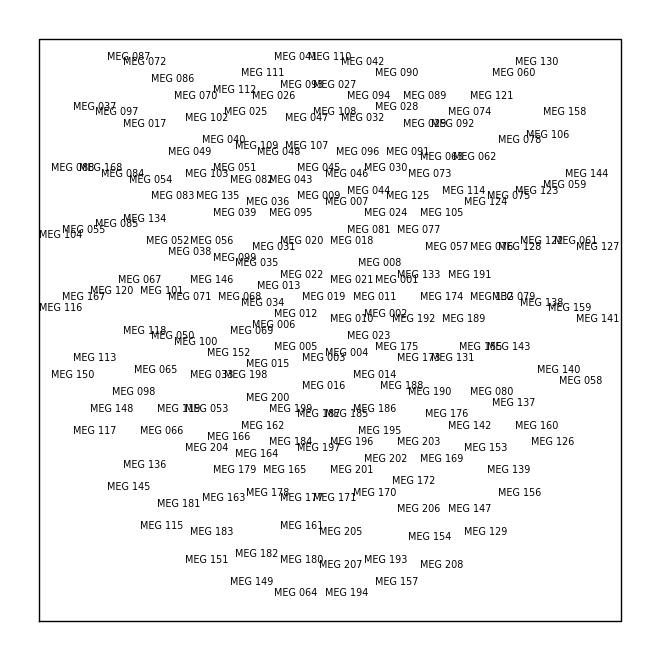

Figure(640x640)


In [2]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')
layout_from_raw = mne.channels.find_layout(raw.info, ch_type='mag')
print(layout_from_raw.plot())

In [ ]:
audio_train = torch.load('/data01/data/MEG/collect_data/audio/audio_tensor_train_raw.pt')
audio_test = torch.load('/data01/data/MEG/collect_data/audio/audio_tensor_test_raw.pt')


## Ridge model on Himalaya

In [ ]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend

X=audio_train.numpy()
y=brain_train.numpy().reshape(13697, -1)
# y=brain_train.numpy()

device_id = 2  
torch.cuda.set_device(device_id)  # Set the current device

backend = set_backend("torch_cuda")
X = backend.asarray(X).to(f'cuda:{device_id}')
y = backend.asarray(y).to(f'cuda:{device_id}')

# for i in tqdm(range(208)):
vm=KernelRidgeCV(alphas=[0.01,1,10,1e2])
vm.fit(X,y)
voxels_scores=vm.score(X,y)
predict=vm.predict(X)



In [8]:
predict.shape

torch.Size([13697, 66768])

## Inference CLAP 

In [ ]:
clap_model_id="laion/larger_clap_music_and_speech"
device_id = 5
feature_extractor = AutoFeatureExtractor.from_pretrained(clap_model_id)
model = ClapAudioModel.from_pretrained("laion/clap-htsat-fused").to(f'cuda:{device_id}')
processor = AutoProcessor.from_pretrained("laion/clap-htsat-fused")
resampler = torchaudio.transforms.Resample(orig_freq=sampling_audio, new_freq=48000)

audio_feat_train = []
with torch.no_grad():
    for wv in tqdm(list(zip(audio_train))):
        wv_tensor = wv[0].float()
        wv = resampler(wv_tensor)
        inputs = processor(audios=wv, return_tensors="pt", sampling_rate=48_000)
        outputs = model(**inputs.to(f'cuda:{device_id}'))
        last_hidden_state = outputs.last_hidden_state
        audio_feat_train.append(last_hidden_state)
    # for wv in tqdm.tqdm(audio_tensor_train):
    #     wv = resampler(wv)
    #     inputs = feature_extractor(wv.squeeze(), return_tensors="pt",sampling_rate=48_000)
    #     audio_features = model.get_audio_features(inputs.input_features.to("cuda:0"))
    #     audio_features = audio_features.cpu()
    #     audio_feat_train.append(audio_features)
    audio_feat_train=torch.stack(audio_feat_train).squeeze()

## Start Here

In [8]:
def normalize_brain_clip(brain_files):
    mean = brain_files.mean(dim=(0, 2), keepdim=True)  
    std = brain_files.std(dim=(0, 2), keepdim=True)    
    normalized_brain = (brain_files - mean) / (std + 1e-9) 
    clipping_brain = torch.clamp(normalized_brain, max=3)

    return normalized_brain, clipping_brain


def normalize_brain_clip_np(brain_files):
    mean = np.mean(brain_files, axis=(0, 2), keepdims=True)
    std = np.std(brain_files, axis=(0, 2), keepdims=True)
    normalized_brain = (brain_files - mean) / (std + 1e-9)
    clipping_brain = np.clip(normalized_brain, a_min=None, a_max=3)
    
    return normalized_brain, clipping_brain




In [31]:
audio_feat_train = torch.load('/srv/nfs-data/sisko/matteoc/meg/audio_clap/audio_clap_train.pt')
print(audio_feat_train.shape)

brain_train = torch.load('/srv/nfs-data/sisko/matteoc/meg/brain_data/09_brain_tensor_train.pt')
print(brain_train.shape)

torch.Size([13697, 768, 2, 32])
torch.Size([13697, 208, 321])


In [32]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
from sklearn.model_selection import train_test_split

X=audio_feat_train.cpu().numpy().reshape(audio_feat_train.shape[0], -1)   # CLAP feature
normalized_brain, clipping_brain = normalize_brain_clip(brain_train)
y=clipping_brain.numpy().reshape(clipping_brain.shape[0], -1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)

device_id = 3  # Change this to your desired GPU index
torch.cuda.set_device(device_id)  # Set the current device

backend = set_backend("torch_cuda")
X_train = backend.asarray(X_train).to(f'cuda:{device_id}')
y_train = backend.asarray(y_train).to(f'cuda:{device_id}')

X_val = backend.asarray(X_val).to(f'cuda:{device_id}')
y_val = backend.asarray(y_val).to(f'cuda:{device_id}')

# for i in tqdm(range(208)):
vm=KernelRidgeCV(alphas=[0.01,1,10,1e2,1e3])
vm.fit(X_train,y_train)
predict=vm.predict(X_val)
voxels_scores=vm.score(X_val,y_val)
predict=predict.reshape(X_val.shape[0], 208, -1)
y_val_true = y_val.reshape(y_val.shape[0], 208, -1)

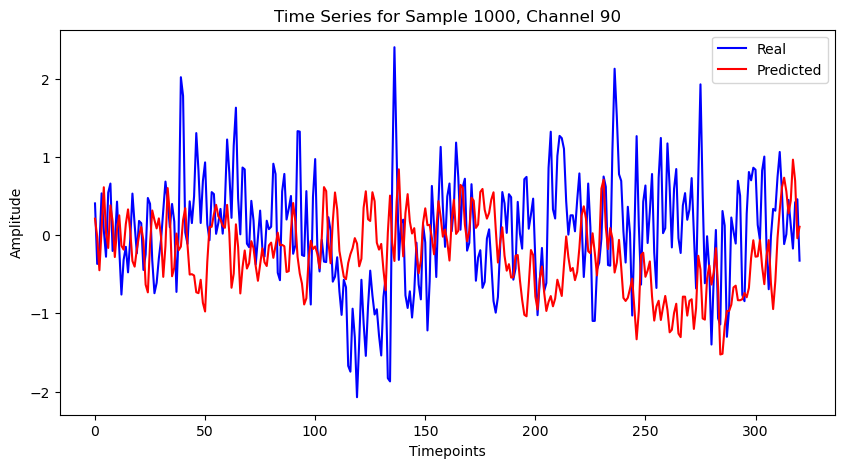

In [72]:
import matplotlib.pyplot as plt

sample = 1000
channel = 90
y_val_true = y_val.reshape(y_val.shape[0], 208, -1)
time_series_real = y_val_true[sample, channel, :]
time_series_pred = predict[sample, channel, :]

plt.figure(figsize=(10, 5))
plt.plot(time_series_real.cpu().numpy(), label='Real', color='blue')
plt.plot(time_series_pred.numpy(), label='Predicted', color='red')

plt.title(f'Time Series for Sample {1000}, Channel {90}')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [ ]:
# TODO: Pearson Correlation rispetto a canali e timepoints (due cicli for)

In [73]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

correlation_matrix = np.zeros((predict.shape[1], predict.shape[2]))  # shape: (channels, timepoints)

for ch in tqdm(range(predict.shape[1])):
    for tp in range(predict.shape[2]):
        corr, _ = stats.pearsonr(y_val_true[:, ch, tp].cpu(), predict[:, ch, tp].cpu())
        correlation_matrix[ch, tp] = corr

mean_correlation = np.mean(correlation_matrix, axis=0)
        

100%|██████████| 208/208 [00:11<00:00, 17.57it/s]


In [ ]:
def moving_average(vector, window_size):

    moving_averages = []
    for i in range(len(vector) - window_size + 1):
        window = vector[i:i + window_size]
        moving_averages.append(np.ma.average(window))
    
    return np.array(moving_averages)

# result_mov = moving_average(mean_correlation, 5)

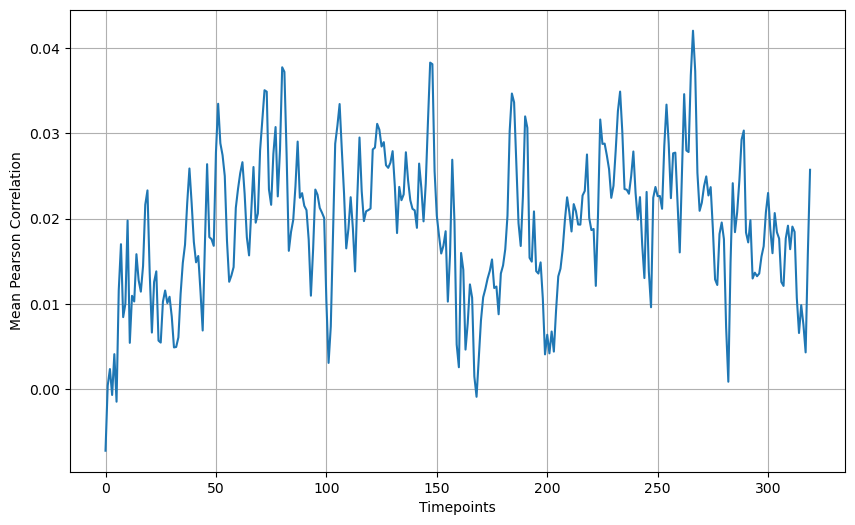

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(mean_correlation[0:-1])
plt.xlabel('Timepoints')
plt.ylabel('Mean Pearson Correlation')
plt.title('')
plt.grid(True)
plt.show()

### Correlation

In [ ]:
from scipy import stats

device = "cuda:3"
n_permutations = 100
pvals_perm = torch.zeros_like(correlation_matrix, device=device)
pred_corr_matrix = torch.zeros_like(correlation_matrix, device=device)

In [ ]:
for ch in tqdm(range(correlation_matrix.shape[0])):
    for tp in range(correlation_matrix.shape[1]):
        real_pc = correlation_matrix[ch, tp]
        perm_pcs = []

        for _ in range(n_permutations):
            # Shuffle predictions along the dimension
            # rand_timep = torch.randperm(predict.shape[0])[0]
            permuted_pred = predict[:, ch, tp][torch.randperm(predict.shape[0])]
            
            # Convert tensors to CPU and numpy for scipy.stats.pearsonr  -->  speed up
            perm_pc, _ = stats.pearsonr(y_val_true[:, ch, tp].cpu().numpy(), permuted_pred.cpu().numpy())
            perm_pcs.append(perm_pc)

        pval = torch.mean((torch.tensor(perm_pcs) >= real_pc.cpu()).float())  
        pvals_perm[ch, tp] = pval
        pred_corr_matrix[ch, tp] = torch.mean(torch.tensor(perm_pcs))

pvals_perm = pvals_perm.cpu().numpy()
pred_corr_matrix = pred_corr_matrix.cpu().numpy()


100%|██████████| 208/208 [25:45<00:00,  7.43s/it]


In [41]:
from statsmodels.stats.multitest import multipletests

_, corrected_p_values, _, _ = multipletests(pvals_perm.flatten(), alpha=0.05, method='fdr_bh')
corrected_p_values = corrected_p_values.reshape(pvals_perm.shape)

significant_corr_matrix = np.where(corrected_p_values < 0.05, correlation_matrix.cpu().numpy(), np.nan)

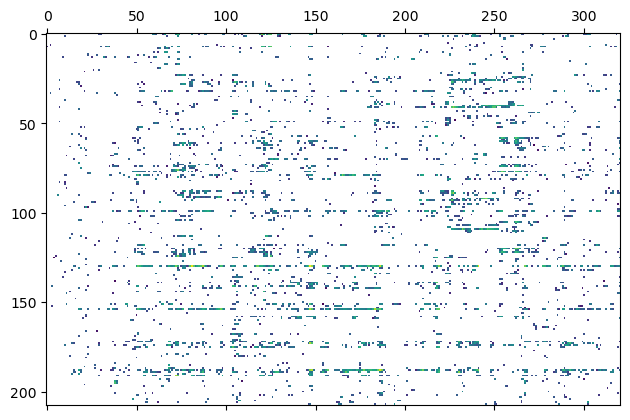

In [42]:
plt.matshow(significant_corr_matrix)

In [ ]:
def get_topomap_gif(raw, correlations, timepoint, vlim, cmap='RdBu_r', sphere=0.13, extrapolate='local', 
                image_interp='cubic', threshold=None, size=8.5, label_to_set='Correlation'):
    meg_indices = mne.pick_types(raw.info, meg=True)
    meg_channel_positions = np.array([raw.info['chs'][i]['loc'][:2] for i in meg_indices])
    correlations = np.array(correlations).reshape(-1)
    if threshold is not None:
        correlations = np.where(correlations > threshold, correlations, np.nan)
    
    fig, ax = plt.subplots()
    topomap = mne.viz.plot_topomap(correlations, meg_channel_positions, ch_type='meg',
                                   names=raw.info['ch_names'], sphere=sphere,
                                   image_interp=image_interp, extrapolate=extrapolate,
                                   border='mean', size=size, cmap=cmap, axes=ax, 
                                   vlim=vlim, show=False)
    cbar = plt.colorbar(topomap[0], ax=ax, fraction=0.02, pad=0.1)   
    cbar.set_label(label_to_set)
    fig.set_size_inches(10, 8)
    ax.set_title(f'Timepoint {timepoint}', fontsize=16)
    fig.canvas.draw()
    
    # Convert figure to numpy array
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return img

In [ ]:
import imageio

gif_path = 'topographic_animation.gif'
frames = []

for time_points in tqdm(range(significant_corr_matrix.shape[1])):
    plot_data = np.nan_to_num(significant_corr_matrix[:, time_points], nan=0)
    correlations = get_topomap_gif(raw, plot_data, time_points, (plot_data.min(), plot_data.max()), threshold=None,
                image_interp='cubic', cmap='RdYlGn', label_to_set='Z-Scores')  # RdYlGn_r
    frames.append(correlations)

# imageio.mimsave(gif_path, frames, duration=1)
# Save frames as GIF using a specified FPS for slower playback
with imageio.get_writer(gif_path, mode='I', fps=2) as writer:  # Decrease fps for a slower GIF
    for frame in frames:
        writer.append_data(frame)

100%|██████████| 321/321 [01:30<00:00,  3.53it/s]


In [23]:
# mean_correlation = np.nanmean(significant_corr_matrix, axis=0)
# std_error = np.nanstd(significant_corr_matrix, axis=0) / np.sqrt(predict.shape[1])

t_values, p_values_ttest = stats.ttest_1samp(correlation_matrix.cpu().numpy(), np.nanmean(pred_corr_matrix, axis=0), axis=0, nan_policy='omit')
_, corrected_p_values_ttest, _, _ = multipletests(p_values_ttest, alpha=0.05, method='fdr_bh')
significant_timesteps = corrected_p_values_ttest < 0.05

In [24]:
significant_timesteps

array([ True, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Fine tuned CLAP - Reconst. Model

In [7]:
def normalize_brain(brain_files):
    mean = brain_files.mean(dim=(0, 2), keepdim=True)  
    std = brain_files.std(dim=(0, 2), keepdim=True)    
    normalized_brain = (brain_files - mean) / (std + 1e-9) 
    normalized_brain = torch.clamp(normalized_brain, max=3)

    return normalized_brain

In [8]:
brain_train = normalize_brain(brain_train)
brain_test  = normalize_brain(brain_test)

In [9]:
class AudioDataset(Dataset):
    def __init__(self, audio_files, brain_files):
        self.audio_files = audio_files
        self.labels = brain_files
        self.processor = ClapProcessor.from_pretrained('laion/clap-htsat-unfused')
        self.resampler = torchaudio.transforms.Resample(orig_freq=sampling_audio, new_freq=48000)

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio = self.audio_files[idx]
        audio_res = self.resampler(audio)
        label = self.labels[idx]
        inputs = self.processor(audios=audio_res, return_tensors="pt", sampling_rate=48000)
        return inputs['input_features'][0], label

In [10]:
train_dataset_full = AudioDataset(audio_train, brain_train)

train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
class CustomClapLSTMModel(nn.Module):
    def __init__(self, clap_model, hidden_dim=208, output_dim=(208, 321)):
        super(CustomClapLSTMModel, self).__init__()
        self.clap = clap_model
        # Freeze all CLAP layers except the last one
        for param in self.clap.parameters():
            param.requires_grad = False
        # self.clap.audio_encoder.layers[-1].blocks[-1].output.dense.requires_grad = True   # provare a fine-tunare tutto l'ultimo layer
        self.clap.audio_encoder.layers[-1].output = True
        
        # self.convt1d = nn.ConvTranspose1d(in_channels=768, out_channels=hidden_dim, kernel_size=5, stride=3, padding=1)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.AdaptiveAvgPool1d(output_dim[1])

    def forward(self, x):

        x = self.clap(x).last_hidden_state       # last_hidden_state shape is [batch, 768, 2, 32]
        batch_size, embd, time, freq = x.shape
        # x = x.view(batch_size, -1, embd)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous().view(batch_size, time*freq, embd)        # [batch, 768, 64]
        # x = self.convt1d(x)    # [batch, 208, 64]
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        
        return x
    

class CLAPFineTunedModel(nn.Module):
    def __init__(self, clap_model, hidden_dim=208, output_dim=(208, 321)):
        super(CLAPFineTunedModel, self).__init__()

        self.clap = clap_model
        # Freeze all CLAP layers except the last one
        for param in self.clap.parameters():
            param.requires_grad = False
        # self.clap.audio_encoder.layers[-1].blocks[-1].output.dense.requires_grad = True   # provare a fine-tunare tutto l'ultimo layer
        self.clap.audio_encoder.layers[-1].output = True

        # Convolutional layers with padding to maintain spatial dimensions
        self.conv1 = nn.Conv2d(in_channels=768, out_channels=256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=hidden_dim, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        
        # self.lstm = nn.LSTM(input_size=64, hidden_size=output_dim[1], num_layers=2, batch_first=True)
        self.upsampler = nn.Upsample(size=(output_dim[1],), mode='linear', align_corners=True)
        
    def forward(self, x):
        # x shape: [batch, 768, 2, 32]
        x = self.clap(x).last_hidden_state
        batch_size, embd, stereo, time = x.shape

        # Apply Conv2D layers
        x = self.conv1(x)  # -> [batch, 256, 2, 32]
        x = self.conv2(x)  # -> [batch, 208, 2, 32]
        x = x.mean(dim=2)
        # TODO: maybe not apply a lstm but upsample 
        
        x = self.upsampler(x)   # -> [batch, 208, 321]
        
        return x

In [12]:
clap_model = ClapAudioModel.from_pretrained("laion/clap-htsat-unfused")
model = CustomClapLSTMModel(clap_model=clap_model).float()

Some weights of ClapAudioModel were not initialized from the model checkpoint at laion/clap-htsat-unfused and are newly initialized: ['audio_encoder.layers.3.blocks.0.layernorm_before.weight', 'audio_encoder.layers.2.blocks.2.attention.self.query.bias', 'audio_encoder.batch_norm.running_var', 'audio_encoder.layers.2.blocks.0.attention.self.key.weight', 'audio_encoder.layers.0.blocks.0.layernorm_after.bias', 'audio_encoder.norm.weight', 'audio_encoder.patch_embed.proj.bias', 'audio_encoder.layers.0.blocks.1.attention.self.value.bias', 'audio_encoder.layers.2.blocks.4.attention.self.value.bias', 'audio_encoder.layers.3.blocks.0.attention.self.value.weight', 'audio_encoder.layers.3.blocks.0.attention.self.value.bias', 'audio_encoder.layers.0.blocks.1.attention.self.query.bias', 'audio_encoder.layers.0.blocks.0.layernorm_before.weight', 'audio_encoder.layers.0.blocks.0.attention.self.value.weight', 'audio_encoder.layers.2.blocks.1.attention.self.key.bias', 'audio_encoder.layers.3.blocks.0.

In [13]:
def pearson_corr_loss(predict, target, device):
    
    pearson_channels = torch.zeros((predict.shape[1], predict.shape[2])).to(device)
    reference = torch.ones(predict.shape[2]).to(device)
    
    for ch in range(predict.shape[1]):
        for tp in range(predict.shape[2]):
            
            pred_chann = predict[:,ch,tp]
            target_chann = target[:,ch,tp]

            pred_centered = pred_chann - torch.mean(pred_chann)
            target_centered = target_chann - torch.mean(target_chann)
            
            covariance = torch.sum(pred_centered * target_centered)
            pred_std = torch.sqrt(torch.sum(pred_centered ** 2))
            target_std = torch.sqrt(torch.sum(target_centered ** 2)) 
            correlation = covariance / (pred_std * target_std + 1e-9)  # Avoid division by zero
            pearson_channels[ch, tp] = correlation
    
    mean_correlation = torch.mean(pearson_channels, axis=0)

    return torch.mean(reference - mean_correlation)


def pearson_corr_loss2(predict, target, device):
    pred_centered = predict - torch.mean(predict, dim=0, keepdim=True)
    target_centered = target - torch.mean(target, dim=0, keepdim=True)

    covariance = torch.sum(pred_centered * target_centered, dim=0)
    pred_std = torch.sqrt(torch.sum(pred_centered ** 2, dim=0))
    target_std = torch.sqrt(torch.sum(target_centered ** 2, dim=0))
    
    correlation = covariance / (pred_std * target_std + 1e-9)  # Avoid division by zero

    # Return 1 - mean correlation for loss
    return (1 - torch.mean(correlation)).to(device)


def contrastive_cosine_loss(pred, real, device, margin=1):
    """
    Compute a contrastive cosine loss that maximizes cosine similarity between each 
    real and predicted matrix for each of the 208 channels, then averages across channels.
    """
    total_loss_similarity = torch.zeros(pred.shape[1]).to(device)  

    for channel in range(pred.shape[1]):
        z_i = nn.functional.normalize(pred[:, channel, :], dim=-1)
        z_j = nn.functional.normalize(real[:, channel, :], dim=-1)
        logits = ((z_i @ z_j.T) * np.exp(margin)).to(device)
        # targets = torch.arange(logits.shape[0]).long().to(logits.device)
        # targets = ((z_j @ z_j.T) * np.exp(margin)).to(device)
        targets = torch.eye(logits.shape[0]).to(device)
        loss_custom = torch.nn.functional.cross_entropy(logits, targets)
        total_loss_similarity[channel] = loss_custom

    return torch.mean(total_loss_similarity)



def hybrid_loss(pred, real, alpha, device, criterion=None):
    # pre_loss = criterion(pred, target)
    contr_loss = contrastive_cosine_loss(pred, real, device, margin=1)
    corr_loss = pearson_corr_loss2(pred, real, device)  
    return alpha * contr_loss + (1 - alpha) * corr_loss

In [21]:
# optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
optimizer = torch.optim.AdamW([
    {'params': model.clap.parameters(), 'lr': 1e-5},  # Small LR for pre-trained model
    {'params': model.lstm.parameters(), 'lr': 1e-4},  
    {'params': model.fc.parameters(), 'lr': 1e-4},   
])
criterion_mse = nn.MSELoss()  
criterion_smooth = nn.SmoothL1Loss()  

# Training loop
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
epochs = 10

for epoch in range(epochs):  
    running_loss = 0.0

    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)
        loss = criterion_mse(outputs, labels)   
        # loss = hybrid_loss(outputs, labels, 0.5, device)   

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()  
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.float().to(device)
            val_labels = val_labels.float().to(device)

            val_outputs = model(val_inputs)
            val_loss += criterion_mse(val_outputs, val_labels) 
            # val_loss += hybrid_loss(val_outputs, val_labels, 0.5, device).item()  

    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_dataloader)}, Validation Loss: {val_loss / len(val_dataloader)}")

    model.train()  # Set model back to training mode

  0%|          | 0/86 [00:00<?, ?it/s]

100%|██████████| 86/86 [01:03<00:00,  1.34it/s]


Epoch 1, Training Loss: 0.9998749231183252, Validation Loss: 0.9984083771705627


100%|██████████| 86/86 [00:58<00:00,  1.48it/s]


Epoch 2, Training Loss: 0.9983835414398549, Validation Loss: 0.9984248876571655


100%|██████████| 86/86 [00:58<00:00,  1.47it/s]


Epoch 3, Training Loss: 0.9981725701065951, Validation Loss: 0.998187243938446


100%|██████████| 86/86 [01:03<00:00,  1.36it/s]


Epoch 4, Training Loss: 0.997992141995319, Validation Loss: 0.9981622099876404


100%|██████████| 86/86 [01:01<00:00,  1.40it/s]


Epoch 5, Training Loss: 0.9981751331063204, Validation Loss: 0.998138964176178


100%|██████████| 86/86 [01:01<00:00,  1.41it/s]


Epoch 6, Training Loss: 0.9981492057789204, Validation Loss: 0.9977542161941528


100%|██████████| 86/86 [01:56<00:00,  1.35s/it]


Epoch 7, Training Loss: 0.997376563937165, Validation Loss: 0.998404324054718


100%|██████████| 86/86 [01:03<00:00,  1.36it/s]


Epoch 8, Training Loss: 0.9970060510690822, Validation Loss: 1.0021098852157593


100%|██████████| 86/86 [02:05<00:00,  1.46s/it]


Epoch 9, Training Loss: 0.9972883601521336, Validation Loss: 0.9981024861335754


100%|██████████| 86/86 [00:59<00:00,  1.44it/s]

Epoch 10, Training Loss: 0.9968902912250784, Validation Loss: 1.001058578491211


In [22]:
val_outputs.shape

torch.Size([20, 208, 321])

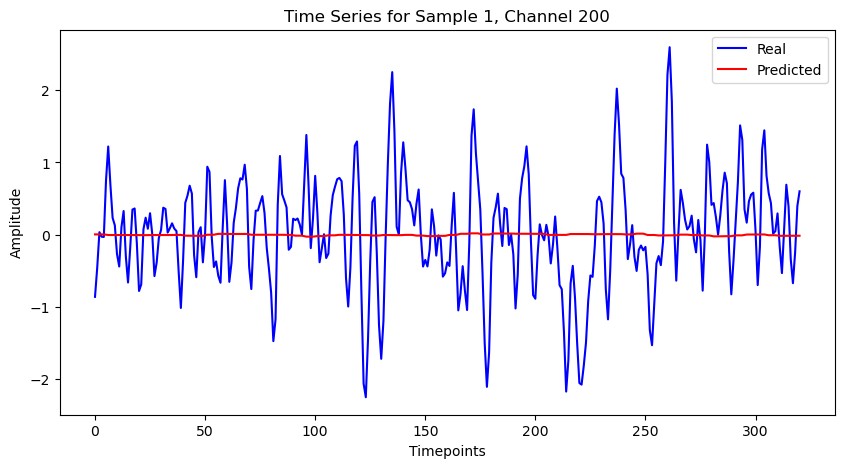

In [23]:
import matplotlib.pyplot as plt

sample = 1
channel = 200
time_series_real = val_labels[sample, channel, :]
time_series_pred = val_outputs[sample, channel, :]

plt.figure(figsize=(10, 5))
plt.plot(time_series_real.cpu().numpy(), label='Real', color='blue')
plt.plot(time_series_pred.cpu().numpy(), label='Predicted', color='red')

plt.title(f'Time Series for Sample {sample}, Channel {channel}')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')
plt.legend()
plt.show()